In [2]:
#kaggle에서 자료 다운로드

import kagglehub

path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


Creating the training dataset...
Found 70295 files belonging to 38 classes.
Creating the validation dataset...
Found 17572 files belonging to 38 classes.

Found the following 38 classes: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


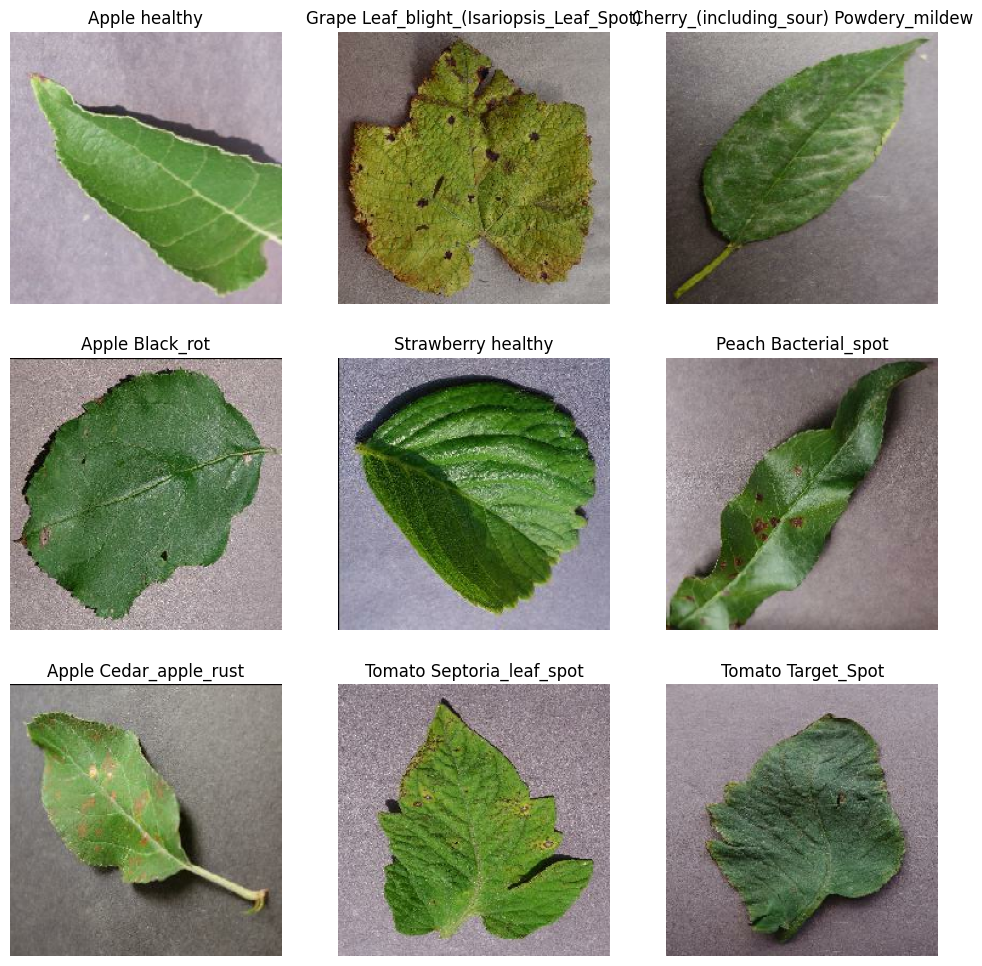

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# --- 1. 경로 설정 ---
# data_dir라는 변수에 경로를 설정합니다.
data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

# 파라메타들의 크기 설정
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

# --- 2. 데이터셋 만들기 ---
print("Creating the training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Creating the validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'valid'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_dataset.class_names
print(f"\nFound the following {len(class_names)} classes: \n{class_names[:5]}")



# 데이터셋 파이프라인 설정 부분 (Notebook 앞부분에 위치)
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)  <-- .cache()를 제거

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# --- 4. Batch of Data 시각화 ---
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # 이미지 픽셀 값을 uint8로 변환하여 표시 (0-255 범위 가정)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i])
        plt.title(class_names[label_index].replace("___", " "))
        plt.axis("off")
plt.show()


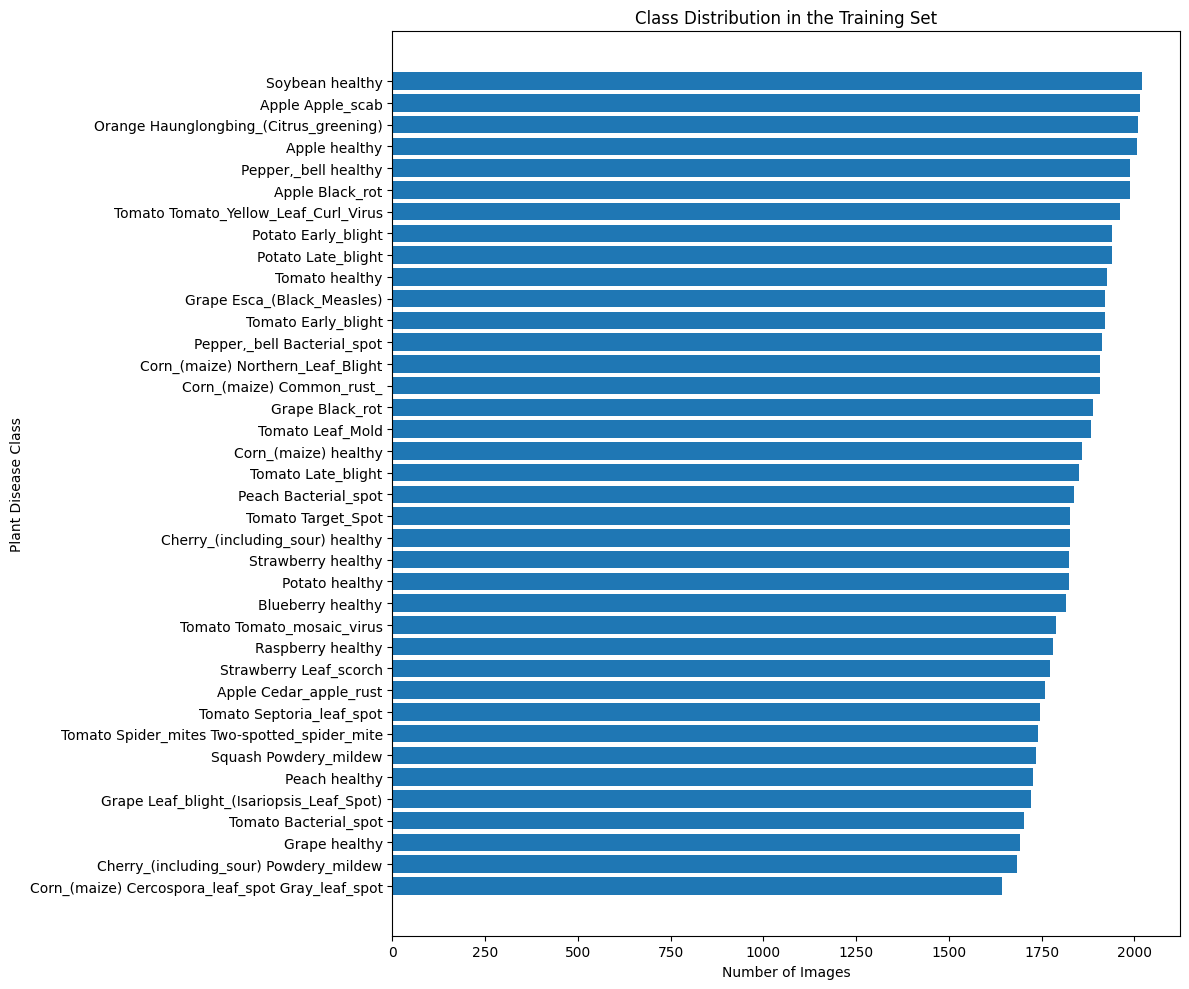

In [4]:
# Path to training directory
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name.replace("___", " ")] = len(os.listdir(class_path))

sorted_counts = sorted(class_counts.items(), key=lambda item: item[1])
sorted_class_names = [item[0] for item in sorted_counts]
sorted_image_counts = [item[1] for item in sorted_counts]

# Plot the distribution
plt.figure(figsize=(12, 10))
plt.barh(sorted_class_names, sorted_image_counts)
plt.xlabel("Number of Images")
plt.ylabel("Plant Disease Class")
plt.title("Class Distribution in the Training Set")
plt.tight_layout()
plt.show()

In [5]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 필수 변수 재정의 ---
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- Data Augmentation Pipeline 구축 ---
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation",
)

# --- Transfer Learning 모델 제작 ---
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# --- 초기 훈련 모델 컴파일 ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset)

base_model.trainable = True

# OPTIONAL FIX: 파인튜닝을 더 나중 레이어에서 시작하여(예: 100 -> 120),
# 훈련 가능한 파라미터 수를 줄여 메모리 부담을 완화
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- 5. 파인 튜닝 재 컴파일 ---
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001)

history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=INITIAL_EPOCHS,
                         validation_data=validation_dataset,
                         callbacks=[early_stopping, reduce_lr])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 256s 112ms/step - accuracy: 0.3157 - loss: 2.5194 - val_accuracy: 0.3497 - val_loss: 2.3359
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.5087 - loss: 1.6623 - val_accuracy: 0.3738 - val_loss: 2.3098
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 203s 71ms/step - accuracy: 0.5271 - loss: 1.5937 - val_accuracy: 0.3742 - val_loss: 2.3152
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.5361 - loss: 1.5601 - val_accuracy: 0.3709 - val_loss: 2.3911
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 169s 77ms/step - accuracy: 0.5442 - loss: 1.5425 - val_accuracy: 0.3700 - val_loss: 2.4139


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 6/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 252s 109ms/step - accuracy: 0.4996 - loss: 2.2242 - val_accuracy: 0.5175 - val_loss: 2.3102 - learning_rate: 1.0000e-04
Epoch 7/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 235s 107ms/step - accuracy: 0.7848 - loss: 0.6738 - val_accuracy: 0.5706 - val_loss: 2.1964 - learning_rate: 1.0000e-04
Epoch 8/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 263s 108ms/step - accuracy: 0.8488 - loss: 0.4740 - val_accuracy: 0.7369 - val_loss: 0.9502 - learning_rate: 1.0000e-04
Epoch 9/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 236s 107ms/step - accuracy: 0.8770 - loss: 0.3776 - val_accuracy: 0.7453 - val_loss: 0.8812 - learning_rate: 1.0000e-04
Epoch 10/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 236s 107ms/step - accuracy: 0.8974 - loss: 0.3176 - val_accuracy: 0.6795 - val_loss: 1.3444 - learning_rate: 1.0000e-04
Epoch 11/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 238s 108ms/step - accuracy: 0.9113 - loss: 0.2717 - val_accuracy: 0.7651 - val_loss: 0.8866 - learning_rate: 1.0000e-04
Epoch 12/25
2197/2197 ━━━━

In [6]:
# 모델 평가 (evaluation) 코드

print("\n--- 모델 최종 성능 평가 시작 ---")

# model.evaluate() 함수를 사용하여 모델의 최종 성능을 측정합니다.
# 이 함수는 [손실(loss), 정확도(accuracy)] 형태의 리스트를 반환합니다.
loss, accuracy = model.evaluate(validation_dataset)

# 결과를 출력합니다.
print("====================================")
print(f"최종 검증 손실 (Validation Loss): {loss:.4f}")
print(f"최종 검증 정확도 (Validation Accuracy): {accuracy:.4f} ({accuracy * 100:.2f}%)")
print("====================================")

# 참고: model.evaluate()는 .fit()의 마지막 에포크 결과와 비슷할 수 있지만,
# EarlyStopping 등으로 인해 복원된 '최적의 가중치'에 대한 정확한 평가를 제공합니다.


--- 모델 최종 성능 평가 시작 ---
550/550 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.9077 - loss: 0.2919
최종 검증 손실 (Validation Loss): 0.4175
최종 검증 정확도 (Validation Accuracy): 0.8735 (87.35%)


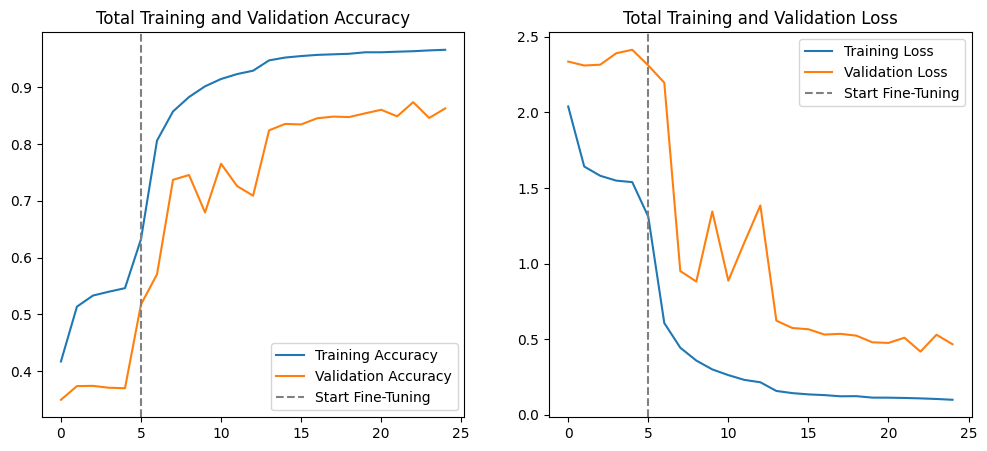

In [7]:
# 8단계 부터 시작
import numpy as np
import matplotlib.pyplot as plt

# --- 8. Evaluate Model Performance (Corrected Version) ---

# Combine the history from the initial training and the fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# FIX: Calculate the epochs range directly from the length of our accuracy list
epochs_range = range(len(acc))

# Plot the combined results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Use INITIAL_EPOCHS (defined in the training cell) to show where fine-tuning started
plt.axvline(INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Total Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Use INITIAL_EPOCHS to show where fine-tuning started
plt.axvline(INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Total Training and Validation Loss')
plt.show()




Making predictions on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

.............

************...


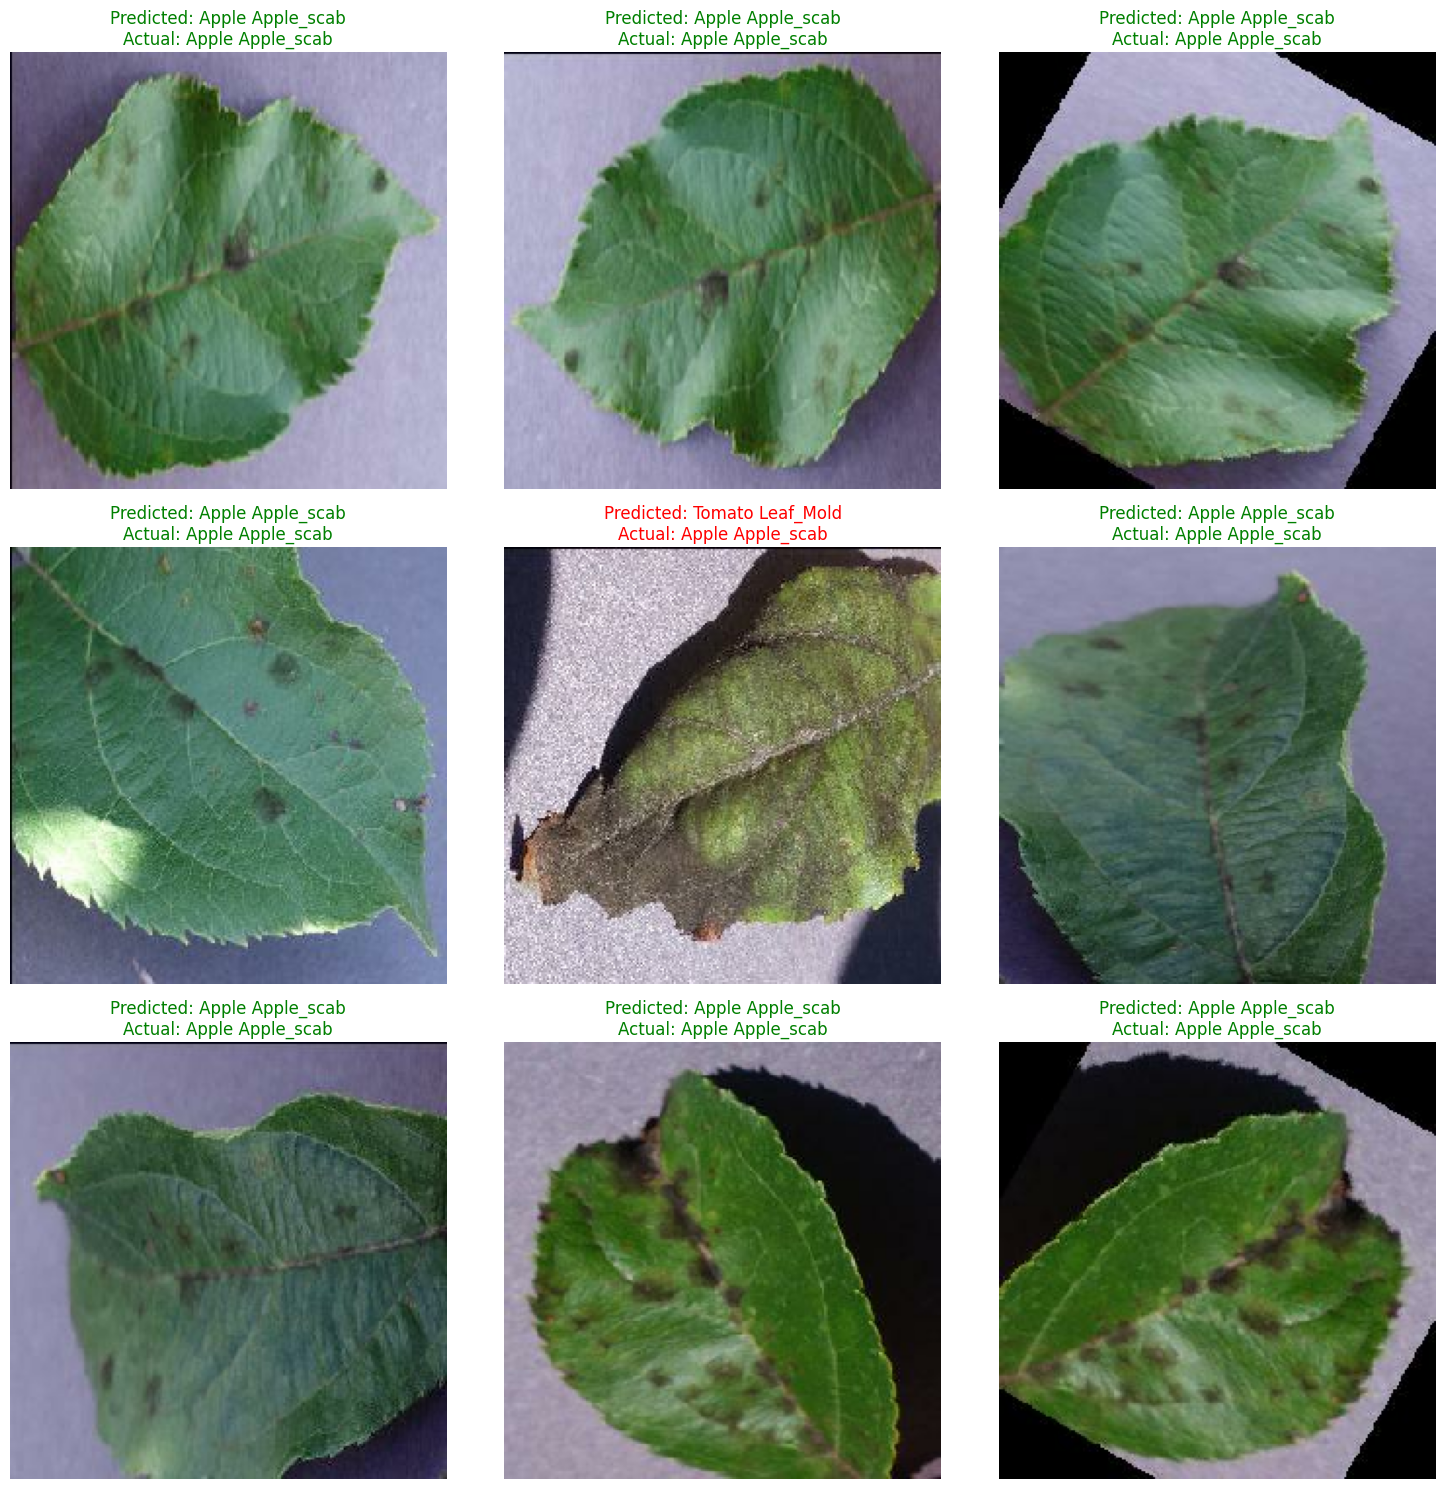

In [8]:
# --- 9. Make Predictions on New Images ---
# This part of your code was correct, as it uses the final 'model' object.
print("\nMaking predictions on a batch of validation images...")

for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    print("\n.............")
    predicted_indices = np.argmax(predictions, axis=1)
    actual_indices = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class = class_names[predicted_indices[i]]
        actual_class = class_names[actual_indices[i]]

        title_color = "green" if predicted_class == actual_class else "red"

        plt.title(f"Predicted: {predicted_class.replace('___', ' ')}\nActual: {actual_class.replace('___', ' ')}", color=title_color)
        plt.axis("off")
    plt.tight_layout()
    print("\n************...")
    plt.show()

Gathering all predictions and labels from the validation set...
550/550 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step

--- CLASSIFICATION REPORT ---
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.85      0.87      0.86       504
                                 Apple___Black_rot       0.80      0.98      0.88       497
                          Apple___Cedar_apple_rust       0.98      0.87      0.92       440
                                   Apple___healthy       0.81      0.95      0.87       502
                               Blueberry___healthy       0.97      0.87      0.92       454
          Cherry_(including_sour)___Powdery_mildew       0.87      0.86      0.86       421
                 Cherry_(including_sour)___healthy       0.82      0.98      0.90       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.93      0.87       410
                       Corn_(maiz

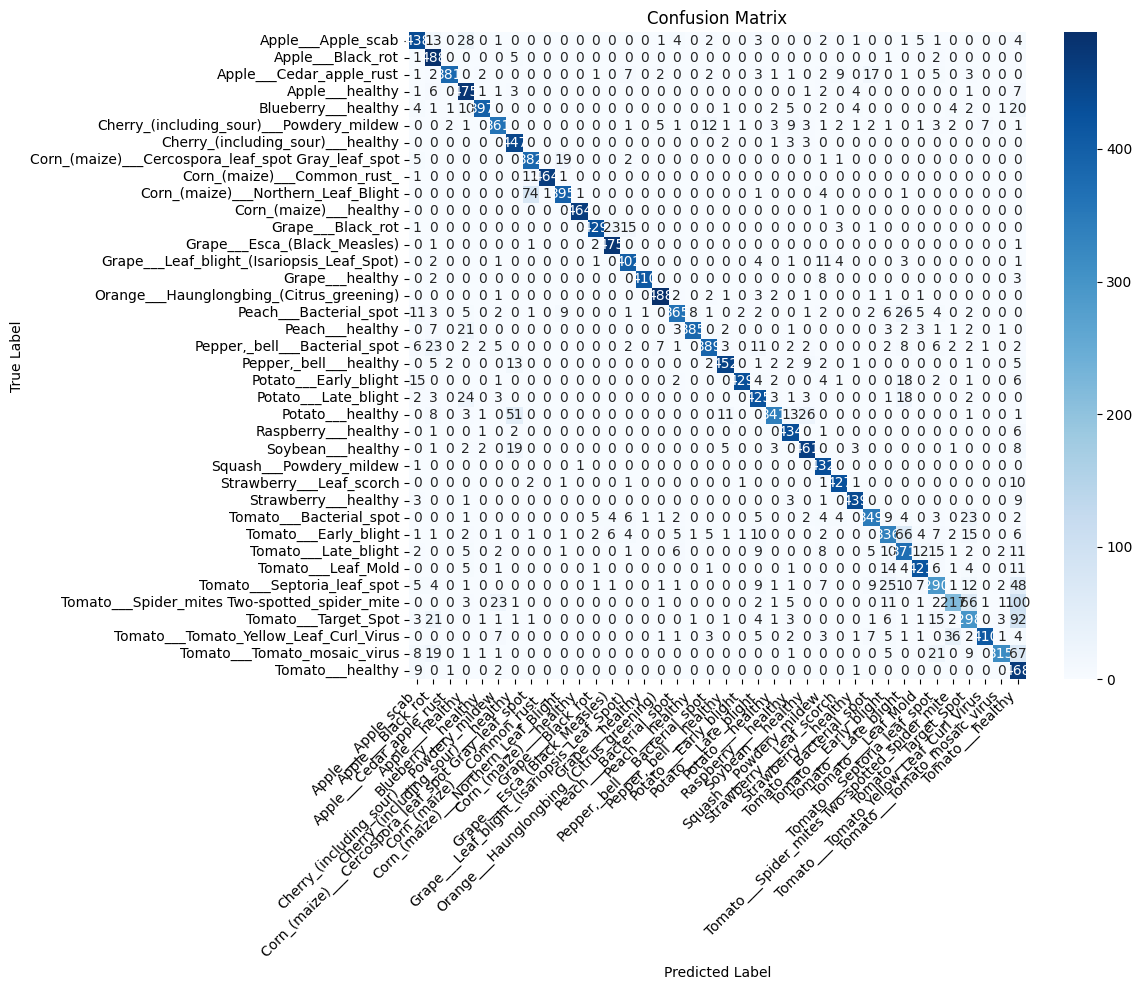

In [9]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Advanced Model Evaluation ---

# To create a report, we need to get all predictions and labels from the validation set.
print("Gathering all predictions and labels from the validation set...")

# Unbatch the validation dataset and convert it to a NumPy iterator
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
# Make predictions on the entire validation dataset
predictions = model.predict(validation_dataset)
# Convert predictions and true labels to class indices
y_pred = np.argmax(predictions, axis=1)
y_true_indices = np.argmax(y_true, axis=1)


# --- 1. Classification Report ---
print("\n--- CLASSIFICATION REPORT ---")
# This report shows precision, recall, and f1-score for every class.
print(classification_report(y_true_indices, y_pred, target_names=class_names))


# --- 2. Confusion Matrix ---
print("\n--- CONFUSION MATRIX ---")
# This matrix shows where the model is getting confused.
conf_matrix = confusion_matrix(y_true_indices, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# Rotate labels for better readability if they overlap
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# --- 10. Save the Model ---
print("Saving model...")

# Define the file path for the saved model
model_save_path = 'plant_disease_model_final.keras'

# Save the entire model to a single file.
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

# You can also save the class names for use in your app
import json
class_names_path = 'class_names_final.json'
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Class names saved to {class_names_path}")

Saving model...
Model saved to plant_disease_model_final.keras
Class names saved to class_names_final.json
